# Visualize BALD Scores for the Test Set During Training
> Resistance is futile.

In [ ]:
# hide
import blackhc.project.script

Appended /home/blackhc/PycharmProjects/bald-ical/src to paths
Switched to directory /home/blackhc/PycharmProjects/bald-ical
%load_ext autoreload
%autoreload 2


Import modules and functions were are going to use.

In [ ]:
import torch

In [ ]:
results = torch.load("extracted_test_scores_results.tpickle")

In [ ]:
import collections
import functools
import math
import os
import re
from collections import namedtuple
from dataclasses import dataclass
from typing import NamedTuple

import laaos
import pandas as pd
import seaborn as sns

In [ ]:
# https://codereview.stackexchange.com/questions/85311/transform-snake-case-to-camelcase
def camel_case_name(snake_case_name):
    return re.sub("_([a-z])", lambda match: match.group(1).upper(), snake_case_name)


__namedtuples = {}


def to_namedtuple(obj, name):
    type_name = "_" + camel_case_name(name)
    if isinstance(obj, dict):
        keys = tuple(obj.keys())
        if keys in __namedtuples:
            nt = __namedtuples[keys]
        else:
            nt = namedtuple(type_name, keys)
            __namedtuples[keys] = nt
        return nt(*(to_namedtuple(v, k) for k, v in obj.items()))
    if isinstance(obj, list):
        item_type_name = type_name + "Item"
        return [to_namedtuple(item, item_type_name) for item in obj]
    if isinstance(obj, set):
        item_type_name = type_name + "Item"
        return {to_namedtuple(item, item_type_name) for item in obj}
    if isinstance(obj, tuple):
        item_type_name = type_name + "Item"
        return tuple(to_namedtuple(item, item_type_name) for item in obj)

    return obj


def get_any(d: dict):
    return next(iter(d.values()))


def handle_map_funcs(func_kv, func_k, func_v, default=None):
    if func_kv:
        assert func_k is None and func_v is None

        def inner(kv):
            return func_kv(*kv)

    elif func_k:
        assert func_v is None

        def inner(kv):
            return func_k(kv[0]), kv[1]

    elif func_v:

        def inner(kv):
            return kv[0], func_v(kv[1])

    else:
        return default
    return inner


def handle_unary_funcs(pred_kv, pred_k, pred_v, default=None):
    if pred_kv:
        assert pred_k is None and pred_v is None

        def inner(kv):
            return pred_kv(*kv)

    elif pred_k:
        assert pred_v is None

        def inner(kv):
            return pred_k(kv[0])

    elif pred_v:

        def inner(kv):
            return pred_v(kv[1])

    else:
        return default
    return inner


def map_dict(d: dict, *, kv=None, k=None, v=None):
    inner = handle_map_funcs(kv, k, v)
    return dict(map(inner, d.items()))


def filter_dict(d: dict, *, kv=None, k=None, v=None):
    inner_pred = handle_unary_funcs(kv, k, v)
    return dict(filter(inner_pred, d.items()))


def sort_dict(d: dict, *, reverse=False, kv=None, k=None, v=None):
    inner_key = handle_unary_funcs(kv, k, v, default=lambda ikv: ikv[0])
    return dict(sorted(d.items(), key=inner_key, reverse=reverse))


def groupby_dict(d: dict, *, key_kv=None, key_k=None, key_v=None, agg=None):
    inner_key = handle_unary_funcs(key_kv, key_k, key_v)

    grouped_by = {}
    for kv in d.items():
        new_key = inner_key(kv)
        if new_key not in grouped_by:
            grouped_by[new_key] = {}
        key, value = kv
        grouped_by[new_key][key] = value

    if agg is not None:
        return map_dict(grouped_by, v=agg)

    return grouped_by

In [ ]:
results = to_namedtuple(results, "Results")

In [ ]:
bald_test_scores = [step.bald_test_scores for _, step in zip(range(50), results.active_learning_steps)]
entropy_test_scores = [step.entropy_test_scores for _, step in zip(range(50), results.active_learning_steps)]

In [ ]:
import scipy.stats
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
test_scores = entropy_test_scores

In [ ]:
sorted_indices = [np.argsort(-scores) for scores in test_scores]

In [ ]:
rows = []
for sample_size in (10000, 4000, 2000,1000,500,200,100, 50, 10, 1):
    merged_indices = list(set.union(*(set(indices[:sample_size].tolist()) for indices in sorted_indices)))
    print(sample_size, len(merged_indices))
    rank_correlations = [scipy.stats.spearmanr(test_scores[0][merged_indices], other_scores[merged_indices]).correlation for other_scores in test_scores]
    rows.append(dict(top_k_samples=f"{sample_size} from each acquisition ({len(merged_indices)})", acquisition=list(range(50)), rank_correlations=rank_correlations))

10000 10000
4000 7084
2000 5023
1000 3496
500 2369
200 1392
100 893
50 547
10 178
1 28


In [ ]:
df = pd.DataFrame.from_dict(rows)
df

,top_k_samples,acquisition,rank_correlations
0,10000 from each acquisition (10000),"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.0, 0.9348150647521507, 0.8487854376758545, ..."
1,4000 from each acquisition (7084),"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.0, 0.8842395180522377, 0.7335213085477783, ..."
2,2000 from each acquisition (5023),"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.0, 0.8264734704966276, 0.6217833149842225, ..."
3,1000 from each acquisition (3496),"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.0, 0.7819312894406188, 0.5471929472849594, ..."
4,500 from each acquisition (2369),"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.9999999999999999, 0.7340076500230266, 0.503..."
5,200 from each acquisition (1392),"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.9999999999999999, 0.7133486985664403, 0.504..."
6,100 from each acquisition (893),"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.0, 0.6955369712248815, 0.5018760124753169, ..."
7,50 from each acquisition (547),"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.9999999999999998, 0.6722264511399673, 0.531..."
8,10 from each acquisition (178),"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.0, 0.6328595032177964, 0.468283242670457, 0..."
9,1 from each acquisition (28),"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.9999999999999998, 0.599343185550082, 0.5440..."


In [ ]:
df = df.explode(["acquisition", "rank_correlations"])

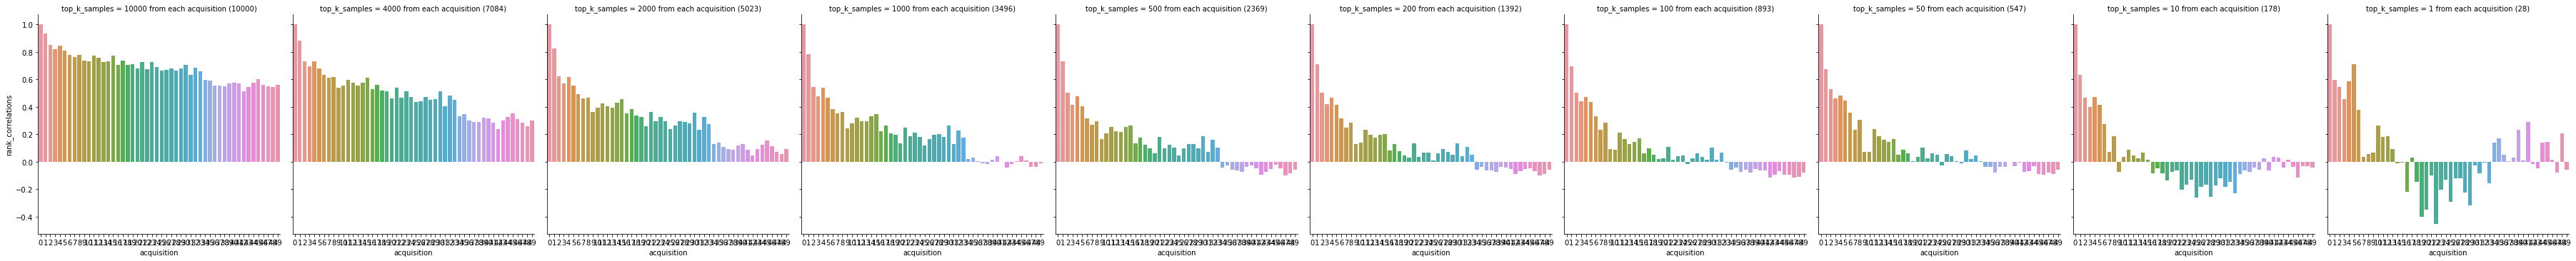

In [ ]:
sns.catplot(data=df, x="acquisition", y="rank_correlations", col="top_k_samples", kind="bar", sharex=True)    